In [1]:
import matplotlib.pyplot as plt

In [ ]:
def parse_xvg(file_path):
    """Safe parser that avoids iterator exhaustion and uneven columns."""
    time, sasa = [], []
    with open(file_path) as f:
        for line in f:
            if line.startswith(("#", "@")) or not line.strip():
                continue
            parts = line.split()
            if len(parts) >= 2:
                try:
                    time.append(float(parts[0]))
                    sasa.append(float(parts[1]))
                except ValueError:
                    continue
    return time, sasa




(array([   40.,    45.,    50., ..., 29990., 29995., 30000.], shape=(5993,)),
 array([4.2228, 4.226 , 4.2304, ..., 1.9296, 1.9412, 1.92  ], shape=(5993,)),
 array([11.4933, 11.364 , 11.1766, ...,  4.7605,  4.7215,  4.8235],
       shape=(5993,)))

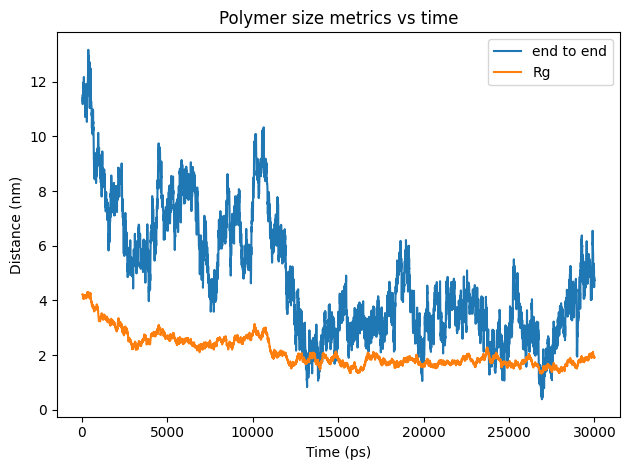

In [9]:
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt

def parse_xvg_xy(path):
    """
    Parse a GROMACS .xvg with XY data and legends.
    Returns: x (np.ndarray), ys (dict legend->np.ndarray)
    """
    path = Path(path)
    lines = path.read_text(errors="replace").splitlines()

    # legend lines look like: @ s0 legend "end to end"
    legends = {}
    for ln in lines:
        m = re.match(r'@\s+s(\d+)\s+legend\s+"(.*)"', ln)
        if m:
            legends[int(m.group(1))] = m.group(2)

    data = []
    for ln in lines:
        if not ln or ln[0] in ("#", "@"):
            continue
        parts = ln.split()
        # numeric rows: time + N series
        try:
            row = [float(x) for x in parts]
        except ValueError:
            continue
        data.append(row)

    arr = np.array(data, dtype=float)
    if arr.ndim != 2 or arr.shape[1] < 2:
        raise ValueError(f"No XY data found in {path}")

    x = arr[:, 0]
    ycols = arr[:, 1:]

    ys = {}
    for i in range(ycols.shape[1]):
        legend = legends.get(i, f"s{i}")
        ys[legend] = ycols[:, i]

    return x, ys

def plot_polystat_rg_ete(polystat_xvg, out_prefix="polystat"):
    t, ys = parse_xvg_xy(polystat_xvg)

    # These are the exact labels GROMACS writes in your file
    # s0: "end to end"
    # s1: "<R\sg\N>"  (Rg)
    if "end to end" not in ys:
        raise KeyError('Could not find legend "end to end" in the XVG legends.')
    if "<R\\sg\\N>" not in ys:
        raise KeyError(r'Could not find legend "<R\sg\N>" (Rg) in the XVG legends.')

    ete = ys["end to end"]
    rg  = ys[r"<R\sg\N>"]

    # --- Plot 1: Rg vs time ---
    plt.figure()
    plt.plot(t, rg)
    plt.xlabel("Time (ps)")
    plt.ylabel("Rg (nm)")
    plt.title("Radius of gyration vs time")
    plt.tight_layout()
    plt.savefig(f"{out_prefix}_Rg_vs_time.png", dpi=200)
    plt.close()

    # --- Plot 2: End-to-end vs time ---
    plt.figure()
    plt.plot(t, ete)
    plt.xlabel("Time (ps)")
    plt.ylabel("End-to-end distance (nm)")
    plt.title("End-to-end distance vs time")
    plt.tight_layout()
    plt.savefig(f"{out_prefix}_end_to_end_vs_time.png", dpi=200)
    plt.close()

    # --- Optional: both on one plot (same units) ---
    plt.figure()
    plt.plot(t, ete, label="end to end")
    plt.plot(t, rg,  label="Rg")
    plt.xlabel("Time (ps)")
    plt.ylabel("Distance (nm)")
    plt.title("Polymer size metrics vs time")
    plt.legend()
    plt.tight_layout()

    return t, rg, ete

# Example usage:
# plot_polystat_rg_ete("/data/polymer_upcycling/all_data/1-2-DCB/C200/20/run1/prod/polystat.xvg",
#                      out_prefix="C200_20_run1")
t, ys = parse_xvg_xy("/data/polymer_upcycling/all_data/1-2-DCB/C200/20/run1/prod/polystat.xvg")
plot_polystat_rg_ete("/data/polymer_upcycling/all_data/1-2-DCB/C200/20/run1/prod/polystat.xvg")

In [10]:
print(list(ys.keys())[:10])


['end to end', '<R\\sg\\N>', '<R\\sg\\N> eig1', '<R\\sg\\N> eig2', '<R\\sg\\N> eig3']


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

BASE = Path("/data/polymer_upcycling/all_data")

def rdf_path(solvent: str, carbon: int, func: int, run: int,
             filename: str = "/data/polymer_upcycling/all_data/1-4-DCB/C200/10/run1/prod/rdf_Cpoly_PDCmolCOM_1-4-DCB_C200_10_run1.xvg") -> Path:
    # solvent like "1-2-DCB" or "1-4-DCB"
    return BASE / solvent / f"C{carbon}" / str(func) / f"run{run}" / "prod" / filename


def plot_rdfs(datasets, solvent="1-2-DCB", title=None, xlim=None):
    """
    datasets: list of dicts or tuples describing which curves to plot.

    Example item formats:
      {"carbon": 20, "func": 0, "run": 1, "label": "C20 – 0%"}
      {"carbon": 200, "func": 0, "run": 2}  # label auto
    """
    plt.figure(figsize=(20, 15))

    for d in datasets:
        carbon = d["carbon"]
        func   = d["func"]
        run    = d.get("run", 1)
        label  = d.get("label", f"C{carbon} – {func}% (run{run})")

        p = rdf_path(solvent, carbon, func, run)
        r, g = parse_xvg(str(p))  # parse_xvg expects a string path

        plt.plot(r, g, lw=2, label=label)

    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='x', which='minor', length=3)

    plt.xlabel("r (nm)")
    plt.ylabel("g(r)")
    if title:
        plt.title(title)
    if xlim:
        plt.xlim(*xlim)

    plt.grid(alpha=0.3, which="both")
    plt.legend(frameon=False, fontsize=11)
    plt.tight_layout()
    plt.show()


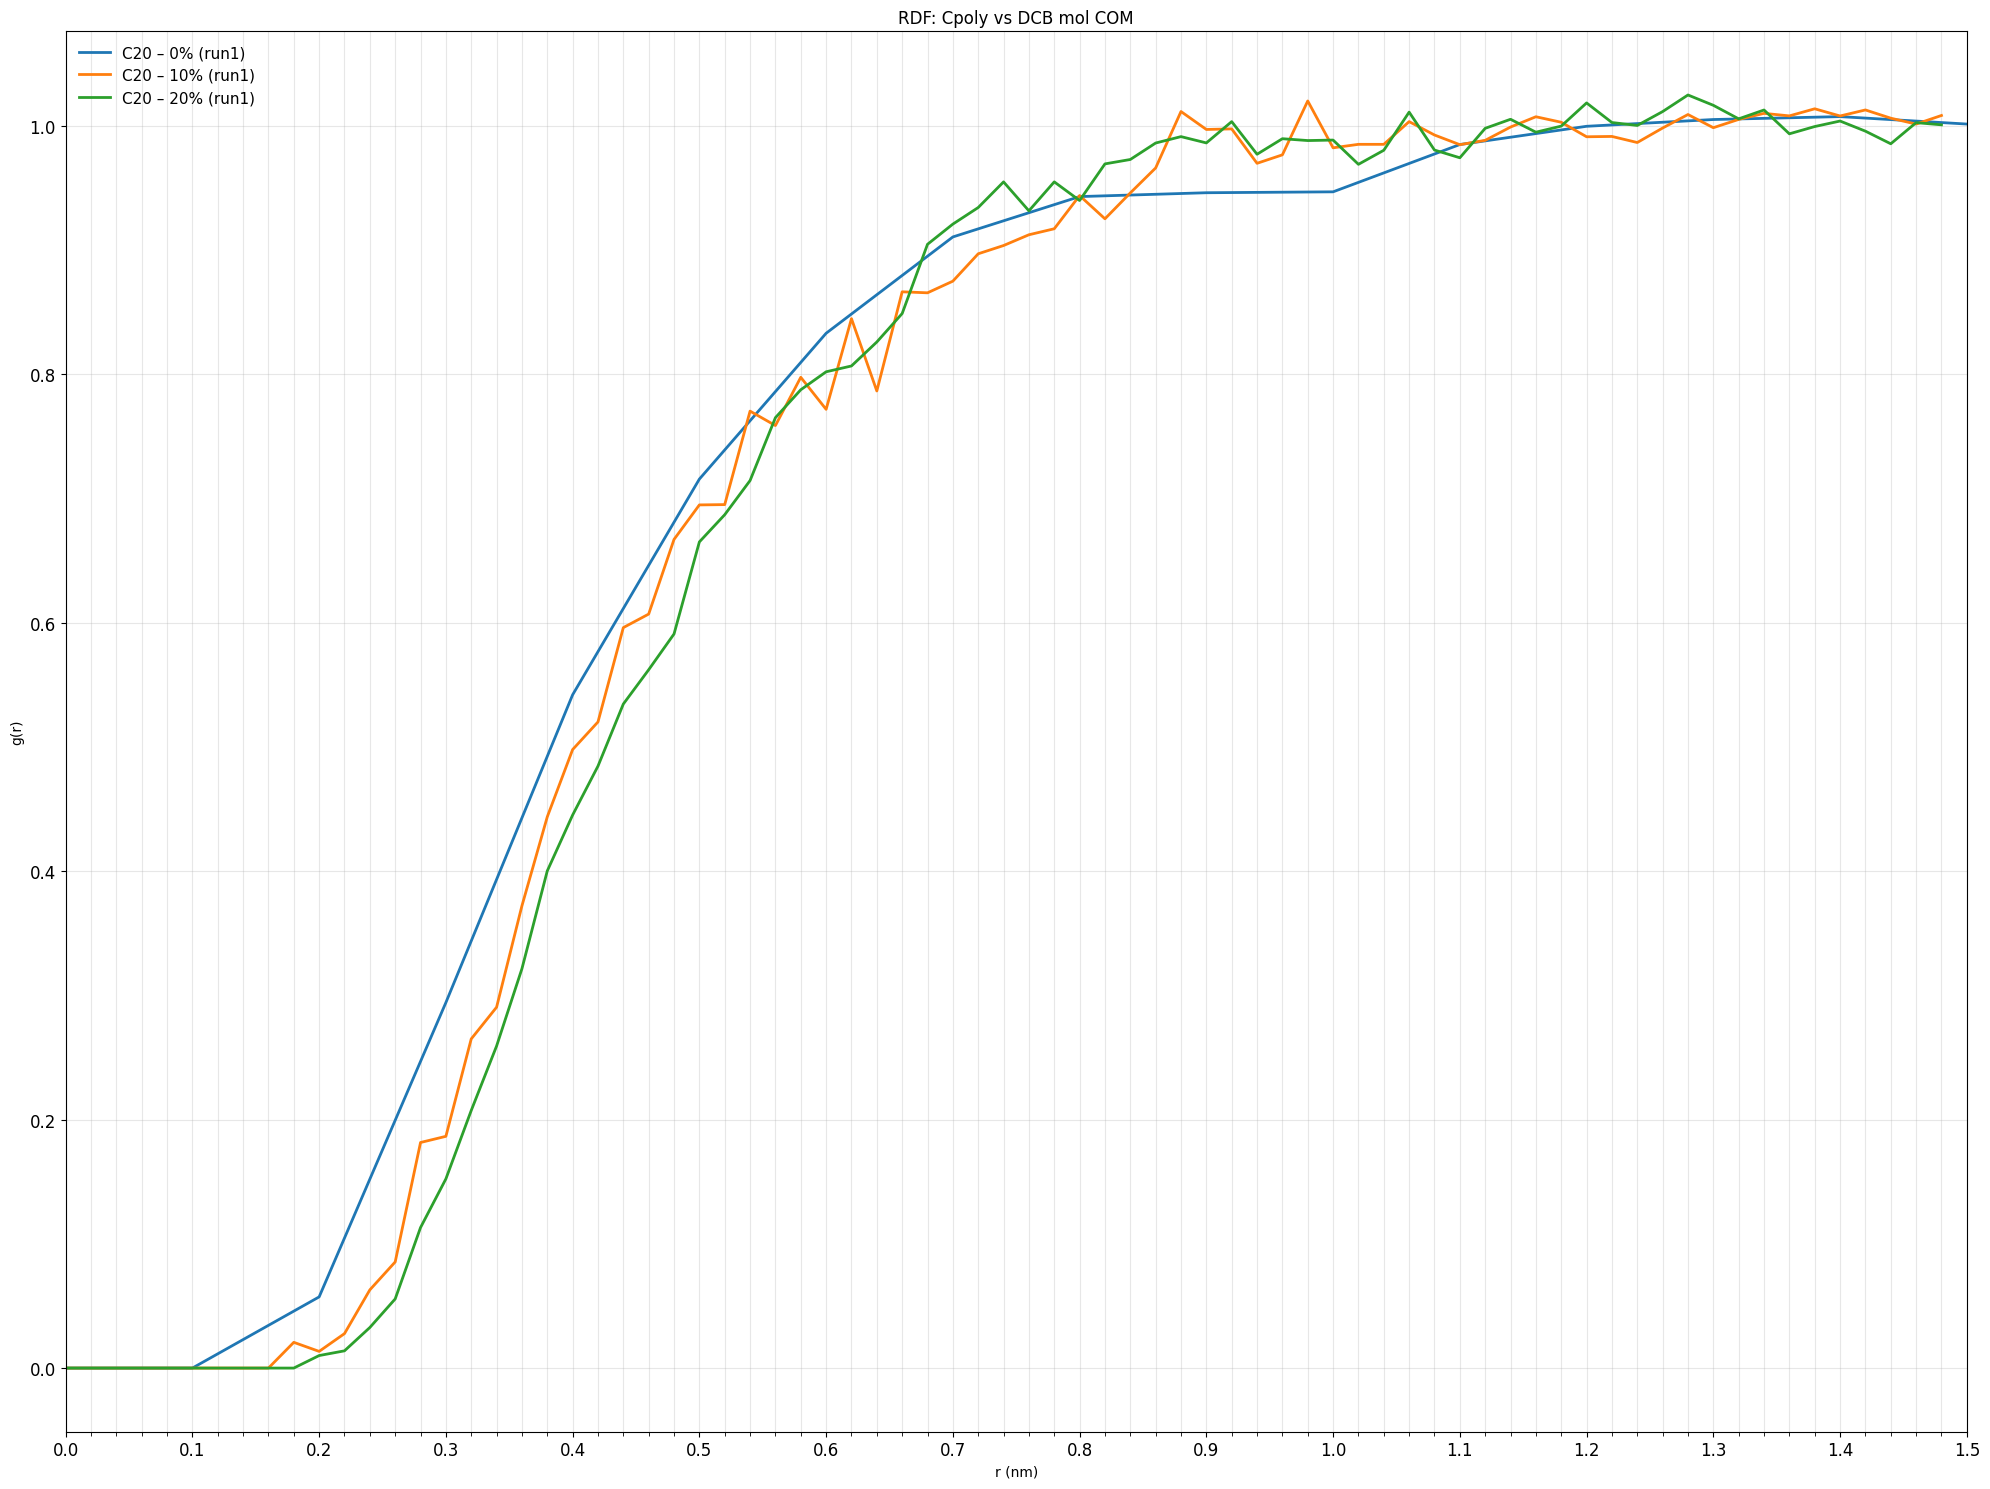

In [ ]:
datasets = [
    {"carbon": 20,  "func": 0,  "run": 1},
    {"carbon": 20,  "func": 10, "run": 1},
    {"carbon": 20,  "func": 20, "run": 1}
]

plot_rdfs(datasets, solvent="1-2-DCB", title="RDF: Cpoly vs DCB mol COM", xlim=(0.0, 1.5))


[MISS] no PDC/DCB RDF in /data/polymer_upcycling/all_data/1-4-DCB/C80/20/run1/prod
[MISS] no PDC/DCB RDF in /data/polymer_upcycling/all_data/1-4-DCB/C200/20/run1/prod
[OK] Saved superplots/SUPERPLOT_1-4-DCB.png


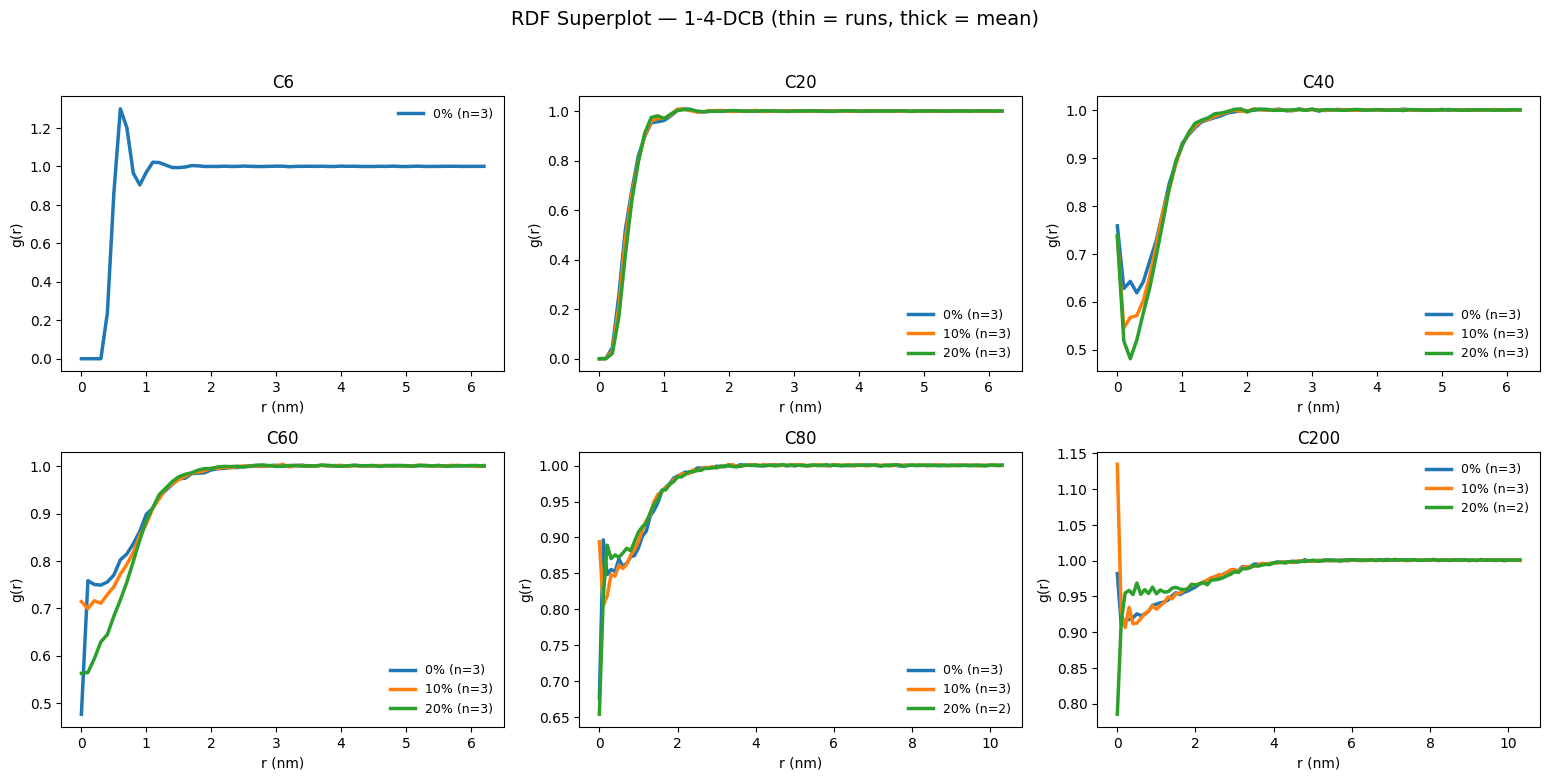

In [11]:
#!/usr/bin/env python3
from __future__ import annotations

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re
import math


def rdf_path_resolve(base: Path, solvent: str, carbon: int, func: int, run: int) -> Path | None:
    """
    Return the existing RDF path for this (carbon, func, run), trying PDC then DCB.
    """
    prod = base / f"C{carbon}" / str(func) / f"run{run}" / "prod"

    candidates = [
        prod / f"rdf_Cpoly_PDCmolCOM_{solvent}_C{carbon}_{func}_run{run}.xvg",
        prod / f"rdf_Cpoly_DCBmolCOM_{solvent}_C{carbon}_{func}_run{run}.xvg",
    ]

    for p in candidates:
        if p.exists():
            return p

    return None



def parse_xvg(path: Path) -> tuple[np.ndarray, np.ndarray]:
    xs, ys = [], []
    with path.open("r", errors="ignore") as fh:
        for line in fh:
            line = line.strip()
            if not line or line.startswith(("#", "@")):
                continue
            parts = re.split(r"\s+", line)
            if len(parts) < 2:
                continue
            try:
                xs.append(float(parts[0]))
                ys.append(float(parts[1]))
            except ValueError:
                continue
    return np.asarray(xs, float), np.asarray(ys, float)


def rdf_path(base: Path, solvent: str, carbon: int, func: int, run: int) -> Path:
    filename = f"rdf_Cpoly_PDCmolCOM_{solvent}_C{carbon}_{func}_run{run}.xvg"
    return base / f"C{carbon}" / str(func) / f"run{run}" / "prod" / filename


def load_runs(
    base: Path,
    solvent: str,
    carbon: int,
    func: int,
    runs: list[int],
    *,
    quiet_missing: bool = False,
) -> tuple[np.ndarray | None, list[np.ndarray]]:
    x_ref = None
    ys: list[np.ndarray] = []

    for run in runs:
        p = rdf_path_resolve(base, solvent, carbon, func, run)

        if p is None:
            if not quiet_missing:
                prod = base / f"C{carbon}" / str(func) / f"run{run}" / "prod"
                print(f"[MISS] no PDC/DCB RDF in {prod}")
            continue

        x, y = parse_xvg(p)

        if x_ref is None:
            x_ref = x
        else:
            # Keep your existing check (though atol=5 is huge for RDF grids; leaving it as-is)
            if len(x) != len(x_ref) or not np.allclose(x, x_ref, rtol=0, atol=5):
                print(f"[SKIP] x-grid mismatch: {p}")
                continue

        ys.append(y)

    return x_ref, ys



def plot_panel(
    ax,
    base: Path,
    solvent: str,
    carbon: int,
    funcs: list[int],
    runs: list[int],
    *,
    thin_runs: bool = True,
):
    # C6 only has 0%
    funcs_use = [0] if carbon == 6 else funcs
    quiet_missing = carbon == 6

    plotted = False

    for func in funcs_use:
        x_ref, ys = load_runs(
            base, solvent, carbon, func, runs, quiet_missing=quiet_missing
        )
        if x_ref is None or len(ys) == 0:
            continue

        Y = np.vstack(ys)
        mean_y = Y.mean(axis=0)

        # Thin individual runs
        if thin_runs:
            for y in ys:
                ax.plot(x_ref, y, alpha=0.2, linewidth=1)

        # Mean curve
        ax.plot(x_ref, mean_y, linewidth=2.5, label=f"{func}% (n={len(ys)})")
        plotted = True

    ax.set_title(f"C{carbon}")
    ax.set_xlabel("r (nm)")
    ax.set_ylabel("g(r)")

    if plotted:
        ax.legend(frameon=False, fontsize=9)
    else:
        ax.text(0.5, 0.5, "no data", ha="center", va="center", transform=ax.transAxes)


def superplot_grid(
    base: Path,
    solvent: str,
    carbons: list[int],
    funcs: list[int],
    runs: list[int],
    outpath: Path,
    *,
    ncols: int = 3,
    thin_runs: bool = True,
):
    n = len(carbons)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5.2 * ncols, 3.8 * nrows),
        sharex=False,
        sharey=False,
    )
    axes = np.atleast_1d(axes).ravel()

    for i, carbon in enumerate(carbons):
        plot_panel(
            axes[i],
            base=base,
            solvent=solvent,
            carbon=carbon,
            funcs=funcs,
            runs=runs,
            thin_runs=thin_runs,
        )

    # Hide unused panels
    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle(
        f"RDF Superplot — {solvent} (thin = runs, thick = mean)",
        y=1.02,
        fontsize=14,
    )
    fig.tight_layout()
    outpath.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"[OK] Saved {outpath}")


if __name__ == "__main__":
    # Run from inside the solvent directory (contains C6/, C20/, ...)
    SOLVENT = "1-4-DCB"
    BASE = Path(f"/data/polymer_upcycling/all_data/{SOLVENT}")
    

    CARBONS = [6, 20, 40, 60, 80, 200]
    FUNCS = [0, 10, 20]
    RUNS = [1, 2, 3]

    superplot_grid(
        base=BASE,
        solvent=SOLVENT,
        carbons=CARBONS,
        funcs=FUNCS,
        runs=RUNS,
        outpath=Path("superplots") / f"SUPERPLOT_{SOLVENT}.png",
        ncols=3,
        thin_runs=False,
    )

 

[OK] Saved superplots/SUPERPLOT_1-4-DCB.png


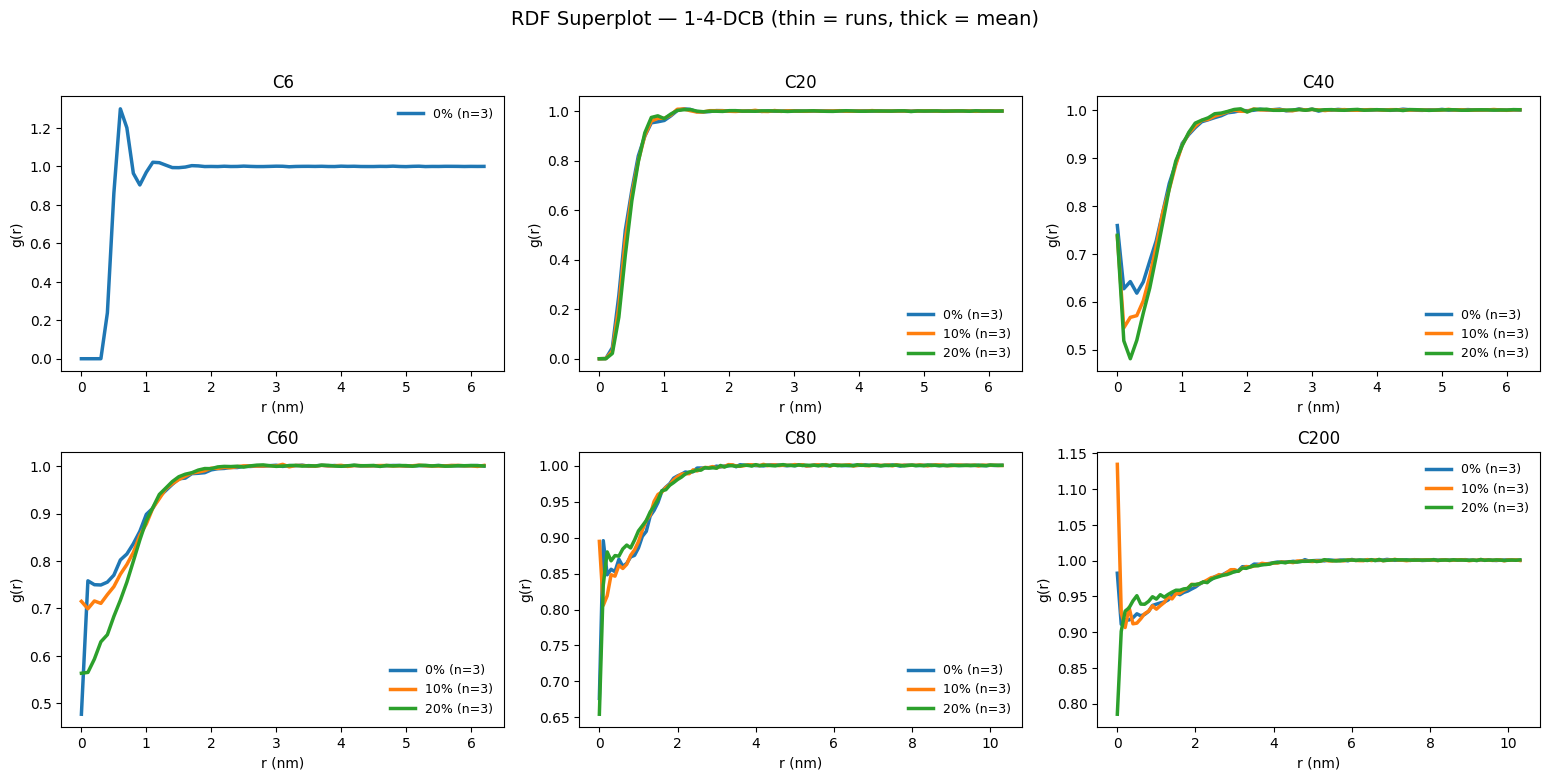

In [3]:
#!/usr/bin/env python3
from __future__ import annotations

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re
import math


def rdf_path_resolve(base: Path, solvent: str, carbon: int, func: int, run: int) -> Path | None:
    """
    Return the existing RDF path for this (carbon, func, run), trying PDC then DCB.
    """
    prod = base / f"C{carbon}" / str(func) / f"run{run}" / "prod"

    candidates = [
        prod / f"rdf_Cpoly_PDCmolCOM_{solvent}_C{carbon}_{func}_run{run}.xvg",
        prod / f"rdf_Cpoly_DCBmolCOM_{solvent}_C{carbon}_{func}_run{run}.xvg",
    ]

    for p in candidates:
        if p.exists():
            return p

    return None



def parse_xvg(path: Path) -> tuple[np.ndarray, np.ndarray]:
    xs, ys = [], []
    with path.open("r", errors="ignore") as fh:
        for line in fh:
            line = line.strip()
            if not line or line.startswith(("#", "@")):
                continue
            parts = re.split(r"\s+", line)
            if len(parts) < 2:
                continue
            try:
                xs.append(float(parts[0]))
                ys.append(float(parts[1]))
            except ValueError:
                continue
    return np.asarray(xs, float), np.asarray(ys, float)


def rdf_path(base: Path, solvent: str, carbon: int, func: int, run: int) -> Path:
    filename = f"rdf_Cpoly_PDCmolCOM_{solvent}_C{carbon}_{func}_run{run}.xvg"
    return base / f"C{carbon}" / str(func) / f"run{run}" / "prod" / filename


def load_runs(
    base: Path,
    solvent: str,
    carbon: int,
    func: int,
    runs: list[int],
    *,
    quiet_missing: bool = False,
) -> tuple[np.ndarray | None, list[np.ndarray]]:
    x_ref = None
    ys: list[np.ndarray] = []

    for run in runs:
        p = rdf_path_resolve(base, solvent, carbon, func, run)

        if p is None:
            if not quiet_missing:
                prod = base / f"C{carbon}" / str(func) / f"run{run}" / "prod"
                print(f"[MISS] no PDC/DCB RDF in {prod}")
            continue

        x, y = parse_xvg(p)

        if x_ref is None:
            x_ref = x
        else:
            # Keep your existing check (though atol=5 is huge for RDF grids; leaving it as-is)
            if len(x) != len(x_ref) or not np.allclose(x, x_ref, rtol=0, atol=5):
                print(f"[SKIP] x-grid mismatch: {p}")
                continue

        ys.append(y)

    return x_ref, ys



def plot_panel(
    ax,
    base: Path,
    solvent: str,
    carbon: int,
    funcs: list[int],
    runs: list[int],
    *,
    thin_runs: bool = True,
):
    # C6 only has 0%
    funcs_use = [0] if carbon == 6 else funcs
    quiet_missing = carbon == 6

    plotted = False

    for func in funcs_use:
        x_ref, ys = load_runs(
            base, solvent, carbon, func, runs, quiet_missing=quiet_missing
        )
        if x_ref is None or len(ys) == 0:
            continue

        Y = np.vstack(ys)
        mean_y = Y.mean(axis=0)

        # Thin individual runs
        if thin_runs:
            for y in ys:
                ax.plot(x_ref, y, alpha=0.2, linewidth=1)

        # Mean curve
        ax.plot(x_ref, mean_y, linewidth=2.5, label=f"{func}% (n={len(ys)})")
        plotted = True

    ax.set_title(f"C{carbon}")
    ax.set_xlabel("r (nm)")
    ax.set_ylabel("g(r)")

    if plotted:
        ax.legend(frameon=False, fontsize=9)
    else:
        ax.text(0.5, 0.5, "no data", ha="center", va="center", transform=ax.transAxes)


def superplot_grid(
    base: Path,
    solvent: str,
    carbons: list[int],
    funcs: list[int],
    runs: list[int],
    outpath: Path,
    *,
    ncols: int = 3,
    thin_runs: bool = True,
):
    n = len(carbons)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5.2 * ncols, 3.8 * nrows),
        sharex=False,
        sharey=False,
    )
    axes = np.atleast_1d(axes).ravel()

    for i, carbon in enumerate(carbons):
        plot_panel(
            axes[i],
            base=base,
            solvent=solvent,
            carbon=carbon,
            funcs=funcs,
            runs=runs,
            thin_runs=thin_runs,
        )

    # Hide unused panels
    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle(
        f"RDF Superplot — {solvent} (thin = runs, thick = mean)",
        y=1.02,
        fontsize=14,
    )
    fig.tight_layout()
    outpath.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"[OK] Saved {outpath}")


if __name__ == "__main__":
    # Run from inside the solvent directory (contains C6/, C20/, ...)
    SOLVENT = "1-4-DCB"
    BASE = Path(f"/data/polymer_upcycling/all_data/{SOLVENT}")
    

    CARBONS = [6, 20, 40, 60, 80, 200]
    FUNCS = [0, 10, 20]
    RUNS = [1, 2, 3]

    superplot_grid(
        base=BASE,
        solvent=SOLVENT,
        carbons=CARBONS,
        funcs=FUNCS,
        runs=RUNS,
        outpath=Path("superplots") / f"SUPERPLOT_{SOLVENT}.png",
        ncols=3,
        thin_runs=False,
    )

 

In [40]:
#!/usr/bin/env python3
from __future__ import annotations
from pathlib import Path
import re
import numpy as np

BASE = Path("/data/polymer_upcycling/all_data/1-2-DCB")
SOLV = "1-2-DCB"

CARBONS = [6, 20, 40, 60, 80, 200]
FUNCS = [0, 10, 20]
RUNS = [1, 2, 3]

def parse_xvg_x(path: Path) -> np.ndarray:
    xs = []
    with path.open("r", errors="ignore") as fh:
        for line in fh:
            line = line.strip()
            if not line or line.startswith(("#", "@")):
                continue
            parts = re.split(r"\s+", line)
            if len(parts) < 2:
                continue
            try:
                xs.append(float(parts[0]))
            except ValueError:
                continue
    return np.asarray(xs, float)

def rdf_path(base: Path, solvent: str, carbon: int, func: int, run: int) -> Path:
    fn = f"rdf_Cpoly_DCBmolCOM_{solvent}_C{carbon}_{func}_run{run}.xvg"
    return base / f"C{carbon}" / str(func) / f"run{run}" / "prod" / fn

def grid_summary(x: np.ndarray) -> dict:
    if len(x) < 2:
        return {"n": len(x), "xmin": float(x.min()) if len(x) else None, "xmax": float(x.max()) if len(x) else None,
                "dx_med": None, "dx_min": None, "dx_max": None}
    dx = np.diff(x)
    return {
        "n": int(len(x)),
        "xmin": float(x[0]),
        "xmax": float(x[-1]),
        "dx_med": float(np.median(dx)),
        "dx_min": float(dx.min()),
        "dx_max": float(dx.max()),
    }

def compare(xref: np.ndarray, x: np.ndarray, tol=1e-12) -> tuple[bool, str]:
    if len(xref) != len(x):
        return False, f"LEN {len(x)} vs {len(xref)}"
    if not np.allclose(x, xref, rtol=0.0, atol=tol):
        # show first differing index
        idx = np.where(np.abs(x - xref) > tol)[0]
        i = int(idx[0]) if len(idx) else -1
        if i >= 0:
            return False, f"VAL mismatch @i={i}: x={x[i]} vs ref={xref[i]}"
        return False, "VAL mismatch"
    return True, "OK"

def main():
    for c in CARBONS:
        funcs = [0] if c == 6 else FUNCS
        for f in funcs:
            # pick run1 as reference if exists; else first run that exists
            ref_path = None
            xref = None
            for r in RUNS:
                p = rdf_path(BASE, SOLV, c, f, r)
                if p.exists():
                    xref = parse_xvg_x(p)
                    ref_path = p
                    break
            if xref is None:
                print(f"\nC{c} func {f}: no files found")
                continue

            refsum = grid_summary(xref)
            print(f"\nC{c} func {f}  REF={ref_path.name}")
            print(f"  ref grid: n={refsum['n']} xmin={refsum['xmin']} xmax={refsum['xmax']} "
                  f"dx~{refsum['dx_med']} (min={refsum['dx_min']}, max={refsum['dx_max']})")

            for r in RUNS:
                p = rdf_path(BASE, SOLV, c, f, r)
                if not p.exists():
                    print(f"  run{r}: MISSING")
                    continue
                x = parse_xvg_x(p)
                ok, why = compare(xref, x, tol=1e-12)
                s = grid_summary(x)
                status = "OK" if ok else "MISMATCH"
                print(f"  run{r}: {status:8s} {why:25s} | n={s['n']} xmax={s['xmax']} dx~{s['dx_med']}")
    print("\nDone.")

if __name__ == "__main__":
    main()



C6 func 0  REF=rdf_Cpoly_DCBmolCOM_1-2-DCB_C6_0_run1.xvg
  ref grid: n=63 xmin=0.0 xmax=6.2 dx~0.10000000000000009 (min=0.09999999999999964, max=0.10000000000000053)
  run1: OK       OK                        | n=63 xmax=6.2 dx~0.10000000000000009
  run2: OK       OK                        | n=63 xmax=6.2 dx~0.10000000000000009
  run3: OK       OK                        | n=63 xmax=6.2 dx~0.10000000000000009

C20 func 0  REF=rdf_Cpoly_DCBmolCOM_1-2-DCB_C20_0_run1.xvg
  ref grid: n=63 xmin=0.0 xmax=6.2 dx~0.10000000000000009 (min=0.09999999999999964, max=0.10000000000000053)
  run1: OK       OK                        | n=63 xmax=6.2 dx~0.10000000000000009
  run2: OK       OK                        | n=63 xmax=6.2 dx~0.10000000000000009
  run3: OK       OK                        | n=63 xmax=6.2 dx~0.10000000000000009

C20 func 10  REF=rdf_Cpoly_DCBmolCOM_1-2-DCB_C20_10_run1.xvg
  ref grid: n=63 xmin=0.0 xmax=6.2 dx~0.10000000000000009 (min=0.09999999999999964, max=0.10000000000000053)
 